---
## 1. Get the data

**Download the data by executing the code below:**

`Notes:`
* This script will download all PDF files from an AWS S3 bucket, maintaining the directory structure, and store them in a DataFrame.
* Ensure you have the necessary AWS credentials and configurations set in a .env file.
* The script uses boto3 to interact with S3, pandas to handle the data, and re for string manipulation.
* The script first downloads all PDF files, then filters these files to obtain those with the most recent and oldest years per company.
* Finally, it extracts the content of the filtered PDFs using the LlamaParse library.
* The extracted content is stored in a new DataFrame, which includes the PDF file names and their corresponding text content.


In [1]:
# Importing the necessary libraries
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from src.plots import(
  analyze_text,
  analyze_sentiment,
  generate_word_cloud,
  plot_common_words,
  display_ngrams_with_plot_side_by_side
)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from src import data_utils

# From the notebook, set the variable to choose the method and call the function
USE_LLAMAPARSE = False  # or False to use fitz
LLAMAPARSE_API_KEY = os.getenv("LLAMAPARSE_API_KEY")

# Call the function to download the PDFs
filtered_pdfs_df = data_utils.download_pdfs_and_convert_to_text(use_llamaparse=USE_LLAMAPARSE, llamaparse_api_key=LLAMAPARSE_API_KEY)
print('Filter pdf df!')

Filter pdf df!


In [3]:
filtered_pdfs_df.head()

,name,content,year,base_name,text
0,NASDAQ_FLWS_2019.pdf,b'%PDF-1.6\r%\xe2\xe3\xcf\xd3\r\n1183 0 obj\r<...,2019.0,NASDAQ_FLWS,"D R I V I N G G R O W T H , \nB U I L D I N ..."
3,NASDAQ_FLWS_2022.pdf,b'%PDF-1.7\r%\xe2\xe3\xcf\xd3\r\n743 0 obj\r<<...,2022.0,NASDAQ_FLWS,"1-800-FLOWERS.COM, INC. \nLETTER TO SHAREHOLDE..."
4,NASDAQ_TXG_2019.pdf,b'%PDF-1.4\n%\xd3\xeb\xe9\xe1\n1 0 obj\n<</Cre...,2019.0,NASDAQ_TXG,Table of Contents\n \n \nUNITED STATES\nSECURI...
6,NASDAQ_TXG_2021.pdf,b'%PDF-1.4\r\n%\xd3\xf4\xcc\xe1\r\n1 0 obj\r\n...,2021.0,NASDAQ_TXG,Table of Contents\nUNITED STATES\nSECURITIES A...
7,NASDAQ_YI_2018.pdf,b'%PDF-1.4\n%\xe4\xe3\xcf\xd2\n1 0 obj\n[/PDF/...,2018.0,NASDAQ_YI,Table of Contents\n \nUNITED STATES\nSECURITIE...



## 2. Normalize the data

**Normalizing text is crucial for preparing data for further analysis, ensuring the text is consistent and easy to process by removing noise and standardizing the format.**

- **Text Cleaning (`clean_text`):** Convert text to lowercase, remove unwanted characters such as punctuation, URLs, HTML tags, and digits.
- **Expand Contractions (`expand_contractions`):** Replace contractions (e.g., "can't" to "cannot") using a predefined dictionary of contractions.
- **Lemmatize Text (`lemmatize_text`):** Tokenize the text and apply lemmatization to convert words to their base form (e.g., "running" to "run").
- **Remove Stopwords (`remove_stopwords`):** Tokenize the text and remove common stop words that do not contribute to the meaning (e.g., "and", "the").
- **Normalize Corpus (`normalize_corpus`):** Combine text chunks into a single string if needed, apply text cleaning, contraction expansion, lemmatization, and stop word removal in sequence, save the cleaned and processed text to a `.txt` file with a specified prefix, and return the normalized text and the output file name.


In [4]:
from src import text_normalizer

# Text cleanup and normalization
cleaned_text = text_normalizer.normalize_corpus(filtered_pdfs_df)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Exploratory Data Analysis (EDA)**

1. Number of Words in the Vocabulary

In [5]:
# Call the analyze_text function
X, num_words, vocab_sample = analyze_text(cleaned_text)

print("Number of words in the vocabulary:", num_words)
print("Words in the vocabulary:", vocab_sample)

Number of words in the vocabulary: 31520
Words in the vocabulary: ['166', '3294523', 'fairness', 'peach', 'clayton', '29219', '6285', 'expensecredit', 'synthetic', 'zbxt']


2. Sentiment of the Text

In [6]:
sentiment = analyze_sentiment(cleaned_text)
print(f"Sentiment of the text: Polarity={sentiment.polarity}, Subjectivity={sentiment.subjectivity}")

Sentiment of the text: Polarity=0.06554139184961945, Subjectivity=0.36751764105248313


3. Word Cloud

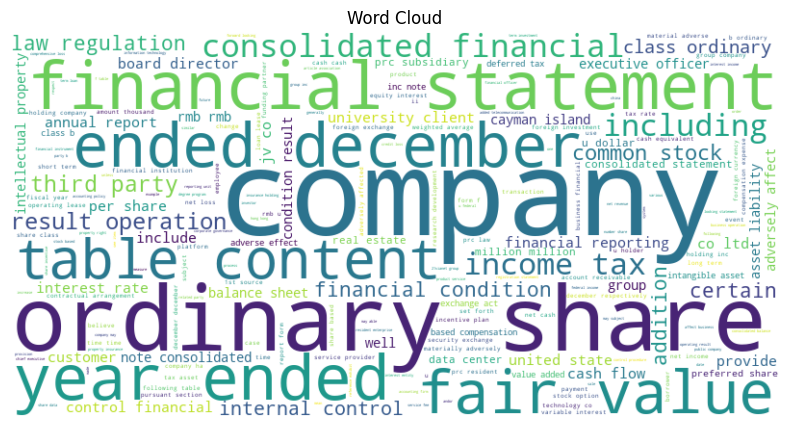

In [7]:
generate_word_cloud(cleaned_text)

4. Common Words Frequency

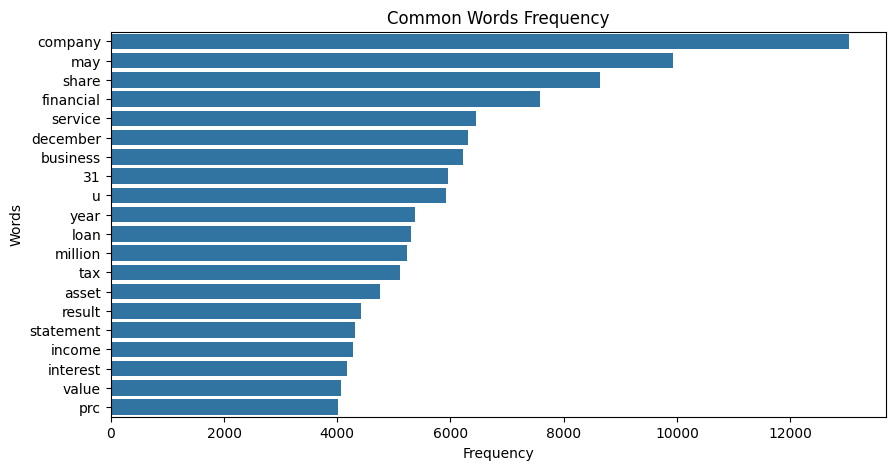

In [8]:
plot_common_words(cleaned_text)

5. Top 10 Bigrams

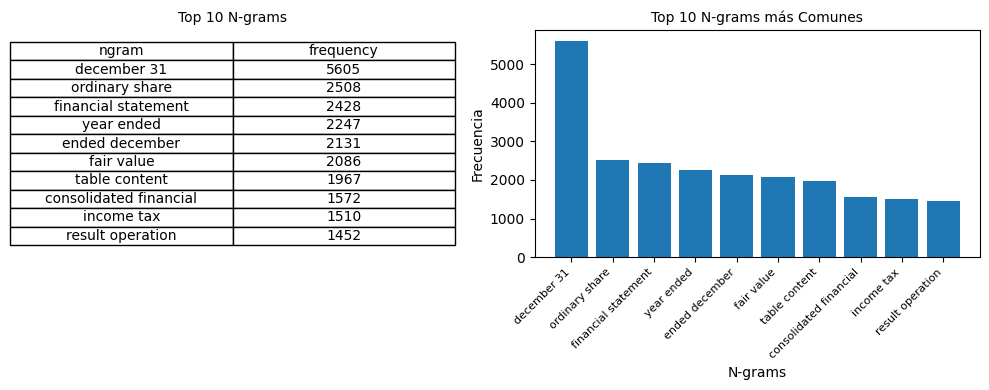

In [9]:
display_ngrams_with_plot_side_by_side(cleaned_text, n=2, top_n=10)

---
## 3. Feature Engineering

In this stage, we have split the texts into fragments and vectorized them so that the machine learning models can understand them. We used the `CharacterTextSplitter` class from LangChain to divide the long texts into more manageable fragments, ensuring that each fragment retains enough context.

After splitting the texts, we store the fragments in a new column of the DataFrame. Then, we use OpenAI embeddings to convert these text fragments into numerical vectors. Embeddings are numerical representations that capture the semantics and context of the texts.

Finally, we store these vectors in a `VectorStore` using FAISS, a library for searching and storing large amounts of vectors. This will allow us to search and retrieve similar text fragments quickly and efficiently.


In [10]:
import os
from src import text_processing

# Create and save the vectorstore
text_processing.create_and_save_vectorstore(cleaned_text, chunk_size=1000, chunk_overlap=200)

## 4. Ragas Evaluation

`ragas` is a library designed for evaluating the performance of question-answering (QA) systems. It provides various metrics to measure the quality of answers generated by these systems. The metrics help in assessing aspects such as the relevance of the answer, faithfulness to the context, precision, recall, correctness, and similarity of the answer.

When this code is executed:

* A dataset will be loaded from a JSON file.
* A set of evaluation metrics will be defined to measure different aspects of the QA system's performance.
* The dataset will be evaluated using the specified metrics.
* The evaluation results will be processed into two DataFrames: one for the global results and one for the results by question.
* The processed results will be returned for analysis or visualization.

In [11]:
from src import ragas_utils
from src import ragas_model

# Read information questions.txt
data_questions = ragas_utils.process_information()

# Process model for add answer and contexts
template = '''Your are a helpful financial chat bot assistant. Answer the following questions considering the history of the conversation:'''
data_ragas = ragas_model.execute(data_questions, template)

# Create data.json
ragas_utils.create_ragas_data_file(data_ragas)

The data.json file was created successfully


In [12]:
from src import ragas_evaluate

#Evaluation
global_result, question_result = ragas_evaluate.get_evaluation()

c:\Users\lucia\OneDrive\Documentos\Anyone\aws_s3_data_downloader\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating train split: 13 examples [00:00, 199.64 examples/s]
Evaluating: 100%|██████████| 78/78 [00:23<00:00,  3.30it/s]


In [13]:
global_result

,Result
context_precision,0.871795
faithfulness,0.692308
answer_relevancy,0.595261
context_recall,0.461538
answer_correctness,0.290430
answer_similarity,0.915571


In [14]:
question_result

,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall,answer_correctness,answer_similarity
0,"What were 1-800-Flowers.com, Inc.'s 2019 tot...","1-800-Flowers.com, Inc.'s 2019 total net reven...",[grow business profitably napcosm resource flo...,"1-800-Flowers.com, Inc.'s 2019 total net reve...",0.833333,1.0,0.978287,1.0,0.247270,0.989082
1,"What was 1-800-Flowers.com, Inc.'s gross prof...","1-800-Flowers.com, Inc.'s gross profit margin ...",[30 2017 gross profit gross profit ear ended j...,"As of July 2019, 1-800-Flowers.com, Inc.'s gr...",1.000000,1.0,0.983010,1.0,0.241768,0.967071
2,"What were 1-800-Flowers.com, Inc.'s net reven...","1-800-Flowers.com, Inc.'s total net revenue in...",[offering fully digital livestreaming floral c...,"In 2021, 1-800-Flowers.com, Inc.'s net revenu...",0.916667,0.0,0.977888,1.0,0.243060,0.972242
3,"What was 1-800-Flowers.com, Inc.'s cost of re...","I don't have information on 1-800-Flowers.com,...",[ing synergistic operating cost saving fiscal ...,"In 2022, 1-800-Flowers.com, Inc.'s cost of re...",0.250000,0.0,0.000000,0.0,0.223462,0.893848
4,"What were 2U, Inc.'s total costs and expenses...","2U, Inc.'s total costs and expenses in 2019 we...",[2022 demonstrates 2u force systemic change pr...,"In 2019, 2U, Inc.'s total costs and expenses ...",0.500000,1.0,0.977625,0.0,0.240330,0.961318
5,"What was the trend in 2U, Inc.'s total stockh...","I don't have the specific information on 2U, I...",[stockholder equity may 22 2019 company issued...,"2U, Inc.'s total stockholders' equity increas...",1.000000,0.0,0.000000,0.0,0.216598,0.866390
6,What were the Companyâ€™s cash interest payme...,The cash interest payments for the year 2022 w...,[paid interest 1222 1670 2250 cash paid tax 86...,The Companyâ€™s cash interest payments were $...,0.916667,1.0,0.000000,0.0,0.734034,0.936138
7,What were the total loans and leases for 2022...,The total loans and leases outstanding for 202...,[2020 1216 million 2021 net loan net loan decr...,"The total loans and leases were $6,011,162 fo...",1.000000,1.0,0.939201,0.0,0.233250,0.933000
8,What were the total loans and leases and accr...,I don't have the specific information needed t...,[total accruing loan nonaccrual total financin...,"Total Loans and Leases: $6.01 billion (2022),...",1.000000,0.0,0.000000,1.0,0.198670,0.794682
9,What were the cash and cash equivalents at th...,The cash and cash equivalents at the end of th...,[payable 7973 5152 33308 4784 total current li...,"Cash and cash equivalents were $107,285 in 20...",1.000000,1.0,0.982779,0.0,0.233678,0.934759


In [15]:
filtered_pdfs_df

,name,content,year,base_name,text
0,NASDAQ_FLWS_2019.pdf,b'%PDF-1.6\r%\xe2\xe3\xcf\xd3\r\n1183 0 obj\r<...,2019.0,NASDAQ_FLWS,"D R I V I N G G R O W T H , \nB U I L D I N ..."
3,NASDAQ_FLWS_2022.pdf,b'%PDF-1.7\r%\xe2\xe3\xcf\xd3\r\n743 0 obj\r<<...,2022.0,NASDAQ_FLWS,"1-800-FLOWERS.COM, INC. \nLETTER TO SHAREHOLDE..."
4,NASDAQ_TXG_2019.pdf,b'%PDF-1.4\n%\xd3\xeb\xe9\xe1\n1 0 obj\n<</Cre...,2019.0,NASDAQ_TXG,Table of Contents\n \n \nUNITED STATES\nSECURI...
6,NASDAQ_TXG_2021.pdf,b'%PDF-1.4\r\n%\xd3\xf4\xcc\xe1\r\n1 0 obj\r\n...,2021.0,NASDAQ_TXG,Table of Contents\nUNITED STATES\nSECURITIES A...
7,NASDAQ_YI_2018.pdf,b'%PDF-1.4\n%\xe4\xe3\xcf\xd2\n1 0 obj\n[/PDF/...,2018.0,NASDAQ_YI,Table of Contents\n \nUNITED STATES\nSECURITIE...
10,NASDAQ_YI_2021.pdf,b'%PDF-1.7\n%\x81\x81\x81\x81\n\n8 0 obj\n<<\n...,2021.0,NASDAQ_YI,Table of Contents\nUNITED STATES\n\nSECURITIES...
11,NASDAQ_PIH_2015.pdf,b'%PDF-1.6\r%\xe2\xe3\xcf\xd3\r\n505 0 obj\r<<...,2015.0,NASDAQ_PIH,"2015 Annual Report \nApril 29, 2016 \n \nFello..."
13,NASDAQ_PIH_2017.pdf,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,2017.0,NASDAQ_PIH,"\n \n \n \n \n \n \nApril 20, 2018 \n \nDear ..."
14,NASDAQ_BCOW_2021.pdf,b'%PDF-1.4\r\n%\xd3\xf4\xcc\xe1\r\n1 0 obj\r\n...,2021.0,NASDAQ_BCOW,Table of Contents\n \n \nUNITED STATES\nSECURI...
15,NASDAQ_BCOW_2022.pdf,b'%PDF-1.4\r\n%\xd3\xf4\xcc\xe1\r\n1 0 obj\r\n...,2022.0,NASDAQ_BCOW,\n \n \nUNITED STATES \nSECURITIES AND EXCH...
